In [1]:
import json

def read_opensignals(filename):
    # Open the file and read line by line
    with open(filename, 'r') as f:
        lines = f.readlines()
        if not lines[0].startswith("# OpenSignals Text File "):
            raise ValueError("Invalid file format. The file should start with '# OpenSignals Text File ...'")
        
        metadata = None
        metadata_num_rows = 1
        for line in lines[1:]:
            if line.startswith("#"):
                metadata_num_rows += 1
                if metadata is not None:
                    continue
                metadata_string = line[1:].replace("# ", "")
                metadata = json.loads(metadata_string)
            else:
                break

        if metadata is None:
            raise ValueError("Invalid file format. Metadata not found.")
        
        # Read the data row by row into the dataframe 
        devices = list(metadata.keys())
        if len(devices) != 1:
            raise ValueError(f"This tool currently only supports parsing data collected from exactly 1 device, but found {len(devices)} device(s) in the metadata.")
        metadata = metadata[devices[0]]


        columns = metadata["column"]
        print(f"Columns: {columns}. Please adjust the graphed index as needed.")
        
        data = []
        for line in lines[metadata_num_rows:]:
            row = line.strip().split("\t")
            data.append((float(row[2])))                         # Adjust the appended index based on which column you want.

        return metadata, data

In [2]:
metadata, data = read_opensignals("../results/OpenSignals/0731-15-05-alternating-eyes.txt")
print(data)

Columns: ['nSeq', 'DI', 'CH1']. Please adjust the graphed index as needed.
[27884.0, 26072.0, 25773.0, 26256.0, 28672.0, 32356.0, 31784.0, 27200.0, 23344.0, 24056.0, 28792.0, 31360.0, 32376.0, 34388.0, 40936.0, 46040.0, 42076.0, 32656.0, 25596.0, 25758.0, 28276.0, 29036.0, 27540.0, 25644.0, 24232.0, 23284.0, 25492.0, 29180.0, 33688.0, 35812.0, 34316.0, 30608.0, 29124.0, 30548.0, 30496.0, 29120.0, 30140.0, 30634.0, 29116.0, 26840.0, 24516.0, 22440.0, 23873.0, 27504.0, 33580.0, 38148.0, 42388.0, 38664.0, 34160.0, 33816.0, 33412.0, 32772.0, 32240.0, 31856.0, 29216.0, 25108.0, 23870.0, 24680.0, 26332.0, 29658.0, 31844.0, 36160.0, 39318.0, 40408.0, 40072.0, 40012.0, 43220.0, 44992.0, 42236.0, 34648.0, 26140.0, 22988.0, 25348.0, 30048.0, 29584.0, 27856.0, 27556.0, 30689.0, 34208.0, 36582.0, 41608.0, 48044.0, 44992.0, 36336.0, 26724.0, 26554.0, 36974.0, 36740.0, 28568.0, 22126.0, 20816.0, 21412.0, 23888.0, 26088.0, 27632.0, 31620.0, 34404.0, 33600.0, 30714.0, 29544.0, 29904.0, 31048.0, 32964.

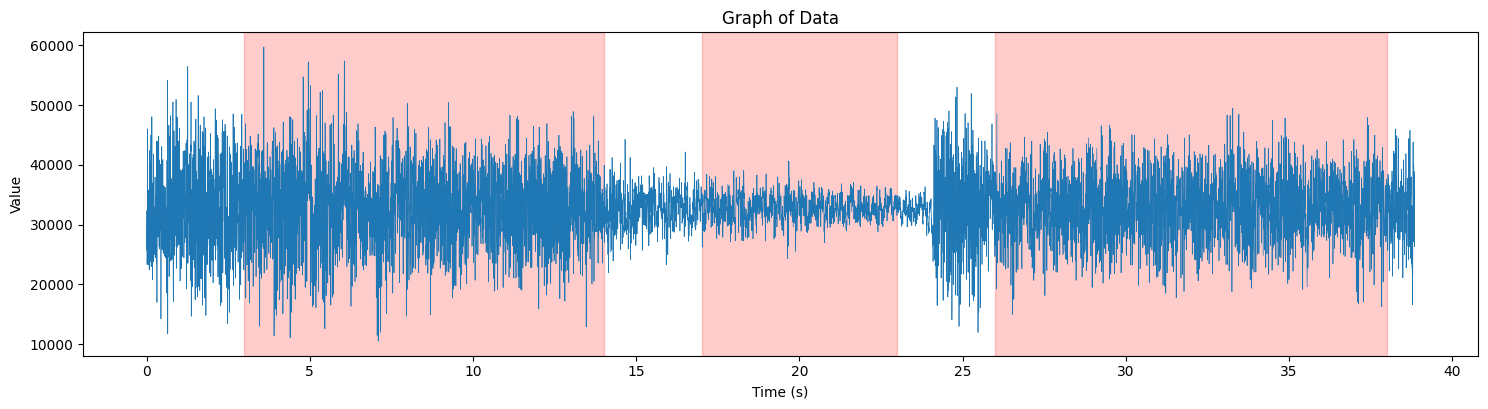

In [3]:
import matplotlib.pyplot as plt

time = [i/500 for i in range(len(data))]
# periods = [ (10, 30), (50, 70), (80, 100) ]
# periods = [ (10, 30), (50, 100), (110, 130) ]
periods = [ (3, 14), (17, 23), (26, 38) ]

plt.figure(figsize=(18, 4.2))
plt.plot(time, data, linewidth=0.5)
for period in periods:
    plt.axvspan(period[0], period[1], color='red', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Graph of Data')
plt.show()

In [4]:
open1 = data[periods[0][0]*500:periods[0][1]*500]
closed = data[periods[1][0]*500:periods[1][1]*500]
open2 = data[periods[2][0]*500:periods[2][1]*500]

# Calculate the mean for each section
mean_open1 = sum(open1) / len(open1)
mean_closed = sum(closed) / len(closed)
mean_open2 = sum(open2) / len(open2)

# Calculate the average deviation from the mean for each section
deviation_open1 = sum(abs(value - mean_open1) for value in open1) / len(open1)
deviation_closed = sum(abs(value - mean_closed) for value in closed) / len(closed)
deviation_open2 = sum(abs(value - mean_open2) for value in open2) / len(open2)

# Print the results
print("Average deviation from mean for open1:", deviation_open1)
print("Average deviation from mean for closed:", deviation_closed)
print("Average deviation from mean for open2:", deviation_open2)

Average deviation from mean for open1: 4744.249255272727
Average deviation from mean for closed: 1552.8782288888888
Average deviation from mean for open2: 3889.781019611111


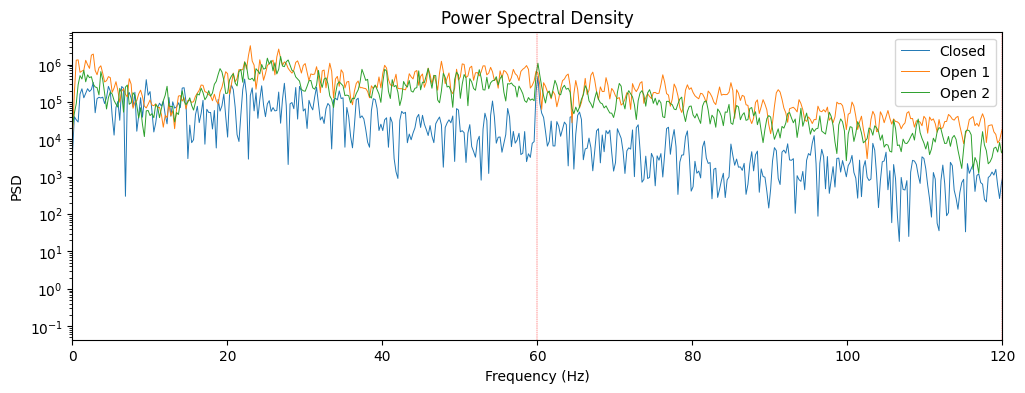

In [5]:
import numpy as np
from scipy import signal

# Calculate the PSD for the 'closed' data
frequencies_closed, psd_closed = signal.welch(closed, fs=500, nperseg=2048)

# Calculate the PSD for the 'open1' data
frequencies_open1, psd_open1 = signal.welch(open1, fs=500, nperseg=2048)

# Calculate the PSD for the 'open2' data
frequencies_open2, psd_open2 = signal.welch(open2, fs=500, nperseg=2048)

plt.figure(figsize=(12, 4))
plt.semilogy(frequencies_closed, psd_closed, label='Closed', linewidth=0.7)
plt.semilogy(frequencies_open1, psd_open1, label='Open 1', linewidth=0.7)
plt.semilogy(frequencies_open2, psd_open2, label='Open 2', linewidth=0.7)
plt.axvline(x=60, color='red', linestyle='--', linewidth=0.3)  # Add a vertical line at 60 Hz
plt.axvline(x=120, color='red', linestyle='--', linewidth=0.3)  # Add a vertical line at 120 Hz
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Power Spectral Density')
plt.legend()
plt.xlim(0, 120)
plt.show()


Text(0.5, 0, 'Time (s)')

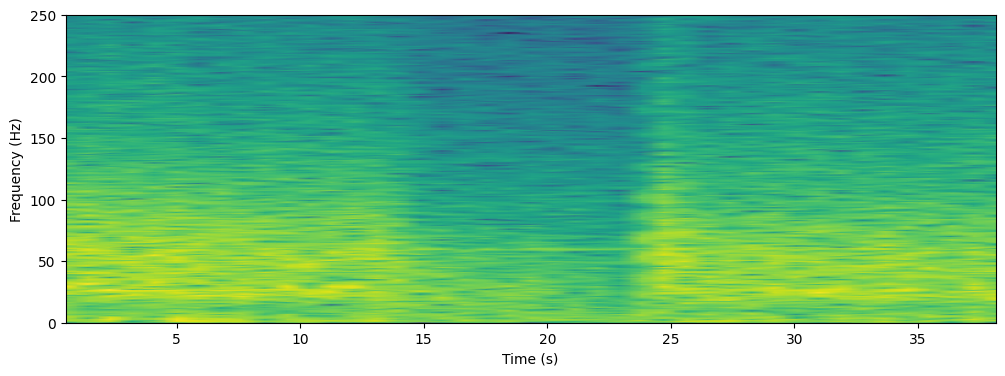

In [6]:
# spectrogram

f, t, Sxx = signal.spectrogram(np.array(data), 500, nperseg=512)
plt.figure(figsize=(12, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')